<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Poverty Prediction</h1> 
<h2 style="text-align: center;" markdown="2">A project of the World Bank's Knowledge for Change Program</h2>
<h3 style="text-align: center;" markdown="3">(KCP, Grant TF0A4534)</h3>


> *This notebook is part of a series that has been developed as an empirical comparative assessment of machine learning classification algorithms applied to poverty prediction. The objectives of this project are to explore how well machine learning algorithms perform when given the task to identify the poor in a given population, and to provide a resource of machine learning techniques for researchers, data scientists, and statisticians in developing countries.*

<h1 style="text-align: center;" markdown="3">Algorithm 1 - Logistic Regression Classifier</h1> 
<h2 style="text-align: center;" markdown="3">Part 2: Indonesia Poverty Prediction</h2> 

# Table of Contents
[Introduction](#introduction)  
[Unbalanced vs Balanced Datasets](#unbalanced-intro)  
&nbsp;&nbsp;&nbsp;[Class Weighting](#class-weighting)  
&nbsp;&nbsp;&nbsp;[Oversampling and Undersampling](#over-and-under-sampling)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Undersampling](#undersampling)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Oversampling](#oversampling)  
[Cross Validation and Parameter Tuning](#cv-and-param-tuning)  
[Feature Selection](#feature-selection)  
[Logistic Regression Summary](#summary)


# Introduction <a class="anchor" id="introduction"></a>

In the previous notebook, we explored building a logistic regression classifier using the Malawi dataset. Now we will apply the same concepts to the Indonesia poverty dataset. Though the datasets are similar, the surveys contain some different questions, so we expect to see some differences in how the classifier performs. 

To begin, we'll load some standard libraries and the Indonesia data

In [1]:
%matplotlib inline

import os
import sys
import json

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from features.process_features import get_vif, standardize

ALGORITHM_NAME = 'lr'
COUNTRY = 'idn'
TRAIN_PATH, TEST_PATH, QUESTIONS_PATH = get_country_filepaths(COUNTRY)

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load text of survey questions for reference
with open(QUESTIONS_PATH, 'r') as fp:
    questions = json.load(fp)
    
# load training data
X_train, y_train, w_train = split_features_labels_weights(TRAIN_PATH)

# summarize loaded data
print('Data has {:,} rows and {:,} columns' \
        .format(*X_train.shape))

print('Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}' \
        .format(*y_train.poor.value_counts(normalize=True, ascending=True)))

# print first 5 rows of data
X_train.head()

Data has 53,132 rows and 453 columns
Percent poor: 9.0% 	Percent non-poor: 91.0%


,geo_district,geo_subdistrict,geo_village,der_hhsize,hld_nbcell,der_nchild10under,der_nmalesover10,der_nfemalesover10,der_nliterate,der_nemployedpast3mo,...,cons_333__Yes,cons_334__Yes,cons_335__Yes,cons_336__Yes,cons_338__Yes,cons_339__Yes,cons_340__Yes,cons_341__Yes,cons_342__Yes,cons_343__Yes
hid,,,,,,,,,,,,,,,,,,,,,
8271030150650101,8271,30,15,5,1,1,2,2,5,1,...,1,0,0,0,0,0,0,0,0,0
7316020200500509,7316,20,13,5,1,4,0,1,2,0,...,1,0,0,0,0,0,0,0,0,0
5108050200860107,5108,50,4,3,0,0,0,3,0,2,...,0,0,0,0,0,0,0,0,1,0
3301190201430210,3301,190,15,2,1,0,1,1,2,2,...,0,0,0,0,0,0,0,0,0,0
6304140250030508,6304,140,4,6,4,1,3,2,5,3,...,0,0,0,0,0,0,0,0,0,0


# Unbalanced vs Balanced Datasets <a class="anchor" id="unbalanced-intro"></a>
One major difference between the Malawi and Indonesia datasets is that the class labels in the Indonesia data are unbalanced. This means that there are much fewer examples of "poor" households (~9%) than "non-poor" (~91%). If we were only using classification accuracy as a metric (The number of correct predictions), this means that we could simply predict that every household is non-poor and have a model with 91% accuracy! However, this would obviously not help us reach our goals for actually understanding and predicting poverty in Indonesia.

As a quick demonstration of this, let's simulate a dummy classifier that predicts '0' with a 50% probability for everything:

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


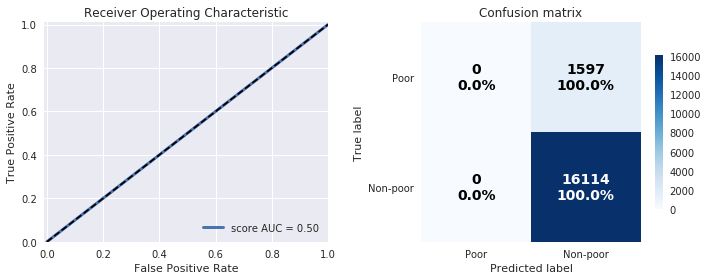

,score
accuracy,0.90983
recall,0
precision,0
f1,0
cross_entropy,0.693147
roc_auc,0.5
cohen_kappa,0


In [3]:
# Load the test set
X_test, y_test, w_test = split_features_labels_weights(TEST_PATH)

# Predict everything as 'non-poor', with 50% probability
y_pred = np.zeros(len(y_test))
y_prob = np.ones(len(y_test)) * 0.5

# Evaluate performance
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, show=True)

As we predicted, the classifier gives us an accuracy of almost 91%, but we can see pretty clearly from the other metrics that it is not performing well. This is one reason why accuracy is not the only metric we use to evaluate the performance of a model. In the case of poverty prediction, we may be more concerned with having a high recall, which in this case is the fraction of 'poor' households we predict correctly as 'poor' over the total number of actual 'poor' households.

Now let's see how an actual LogisticRegression classifier is affected by unbalanced data. We'll start with a small dataset of just a few features as we did with Malawi and see if the same multicollinearity issues exist.

To avoid duplicating code, we've added the `get_vif` and `standardize` functions in `utils.py`

In [4]:
# Select a few columns for this example
selected_columns = [
    'der_hhsize', 
    'der_nchild10under', 
    'der_nmalesover10', 
    'der_nfemalesover10',
    'der_nliterate', 
    'der_nemployedpast3mo',
    'hld_lighting__PLN electricity',
    'hld_toilet__None',
    'cons_054__Yes',
    'cons_029__Yes'
]

print("X shape with selected columns:", X_train[selected_columns].shape)

X shape with selected columns: (53132, 10)


In [5]:
get_vif(X_train[selected_columns])

der_hhsize                       493778.058947
der_nchild10under                 45204.683420
der_nmalesover10                  85109.154173
der_nfemalesover10                82670.159500
der_nliterate                        26.672113
der_nemployedpast3mo                  6.927667
hld_lighting__PLN electricity         3.588184
hld_toilet__None                      1.301448
cons_054__Yes                         1.064163
cons_029__Yes                         1.121186
Name: variance_inflaction_factor, dtype: float64

Several of these VIF results are very high, so let's standardize the numeric data and check again.

In [6]:
standardize(X_train)
get_vif(X_train[selected_columns])

der_hhsize                       81844.521107
der_nchild10under                25112.865108
der_nmalesover10                 23366.441612
der_nfemalesover10               19355.593334
der_nliterate                        5.382199
der_nemployedpast3mo                 1.664301
hld_lighting__PLN electricity        1.293098
hld_toilet__None                     1.179499
cons_054__Yes                        1.062021
cons_029__Yes                        1.118057
Name: variance_inflaction_factor, dtype: float64

These VIF results are still very high, so once again let's remove the `der_hhsize` feature

In [7]:
selected_columns.remove('der_hhsize')
print(selected_columns)

get_vif(X_train[selected_columns])

['der_nchild10under', 'der_nmalesover10', 'der_nfemalesover10', 'der_nliterate', 'der_nemployedpast3mo', 'hld_lighting__PLN electricity', 'hld_toilet__None', 'cons_054__Yes', 'cons_029__Yes']


der_nchild10under                1.475370
der_nmalesover10                 3.327929
der_nfemalesover10               2.574168
der_nliterate                    5.382198
der_nemployedpast3mo             1.664297
hld_lighting__PLN electricity    1.293087
hld_toilet__None                 1.179485
cons_054__Yes                    1.062019
cons_029__Yes                    1.118052
Name: variance_inflaction_factor, dtype: float64

Now the VIF results are back in an acceptable range, so let's use these features and train a LogisticRegression model. We can use the `load_data` function in the `load_data.py` module, which uses our `standardize` function by default.

We'll also store these selected features in `IDN_SIMPLE_FEATURES` so we can use the same subset in other notebooks.

In [8]:
# Same method for getting the coefficients as we used with Malawi
def get_coefs_df(X, coefs, index=None):
    coefs_df = pd.DataFrame(np.std(X, 0)*coefs)
    coefs_df.columns = ["coef_std"]
    coefs_df['coef'] = coefs
    coefs_df['abs'] = coefs_df.coef_std.apply(abs)
    if index is not None:
        coefs_df.index = index
    return coefs_df

CPU times: user 128 ms, sys: 42 µs, total: 128 ms
Wall time: 128 ms
CPU times: user 206 ms, sys: 1.45 s, total: 1.66 s
Wall time: 76.4 ms
In-sample score: 90.98%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


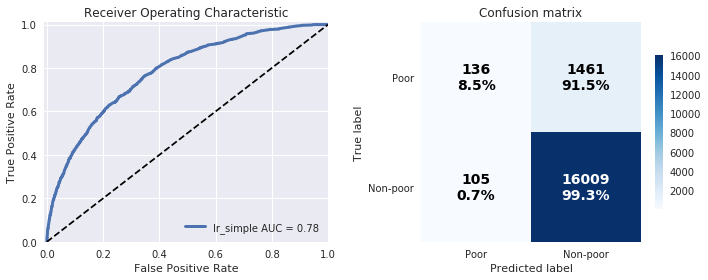

,lr_simple
accuracy,0.91158
recall,0.0851597
precision,0.564315
f1,0.147987
cross_entropy,0.256817
roc_auc,0.781848
cohen_kappa,0.127352


Actual poverty rate: 11.38% 
Predicted poverty rate: 1.37% 


In [9]:
from sklearn.linear_model import LogisticRegression

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, selected_columns=selected_columns)

# Fit the model
model = LogisticRegression()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Store coefficients
coefs = get_coefs_df(X_train, model.coef_[0])

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, selected_columns=selected_columns)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob,
                                    store_model=True,
                                    model_name='simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

Here we see that the recall is only 9%, which means we do a very poor job of predicting that poor households are poor. This is probably due to the fact that we have so few examples of poor households to train the model on. An interesting metric to consider is the [Cohen's Kappa](https://en.wikipedia.org/wiki/Cohen%27s_kappa) metric. This normalizes the classification accuracy by the imbalance of the classes in the data. Here we can see it is only 8%.

### Class Weighting <a class="anchor" id="class-weighting">
Scikit-Learn offers several methods to deal with unbalanced classes. One is to adjust the weights of the classes to be inversely proportional to the class frequencies. This can be a simple way to increase the recall of the model, but usually has a negative effect on the accuracy and precision.

CPU times: user 107 ms, sys: 0 ns, total: 107 ms
Wall time: 110 ms
CPU times: user 74.9 ms, sys: 628 ms, total: 702 ms
Wall time: 32.5 ms
In-sample score: 73.14%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


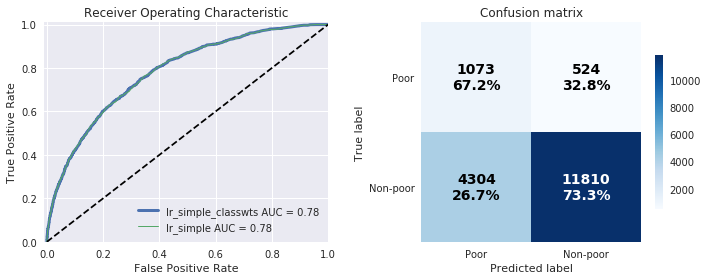

,lr_simple_classwts,lr_simple
accuracy,0.727401,0.91158
recall,0.671885,0.0851597
precision,0.199554,0.564315
f1,0.307714,0.147987
cross_entropy,0.568207,0.256817
roc_auc,0.781698,0.781848
cohen_kappa,0.195911,0.127352


Actual poverty rate: 11.38% 
Predicted poverty rate: 35.59% 


In [10]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, selected_columns=selected_columns)

# Fit the model using class_weight='balanced' 
model = LogisticRegression(class_weight='balanced')
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Store coefficients
coefs = get_coefs_df(X_train[selected_columns], model.coef_[0])

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, selected_columns=selected_columns)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, 
                                    compare_models='lr_simple',
                                    store_model=True,
                                    model_name='simple_classwts',
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

This did not change the AUC much, but it made a significant improvement to the model's recall, bringing it up to about 67%. 

Now let's try doing this with the full feature set with sample weights and see the effects:


CPU times: user 24.7 s, sys: 234 ms, total: 24.9 s
Wall time: 25 s
CPU times: user 228 ms, sys: 775 ms, total: 1 s
Wall time: 334 ms
In-sample score: 92.80%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


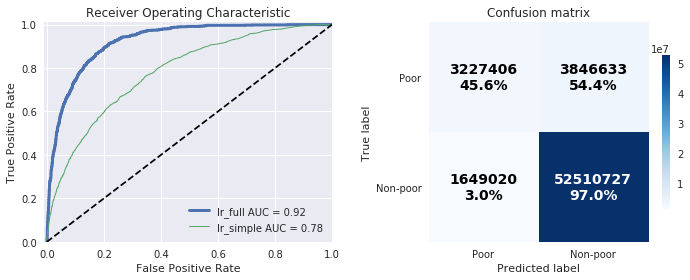

,lr_full,lr_simple
accuracy,0.910251,0.91158
recall,0.456232,0.0851597
precision,0.661838,0.564315
f1,0.540131,0.147987
cross_entropy,0.212947,0.256817
roc_auc,0.923198,0.781848
cohen_kappa,0.483497,0.127352


Actual poverty rate: 11.38% 
Predicted poverty rate: 8.25% 


In [11]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = LogisticRegression()
%time model.fit(X_train, y_train, sample_weight=w_train)

# Get an initial score
%time score = model.score(X_train, y_train, sample_weight=w_train)
print("In-sample score: {:0.2%}".format(score))
coefs = get_coefs_df(X_train, model.coef_[0])['abs']

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models='lr_simple',
                                    store_model=True,
                                    model_name='full', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

This is much better than with the smaller feature set, but we still only have a recall of ~43%, which is not very good. Let's try using the balanced class_weights and see how it improves

CPU times: user 34.3 s, sys: 198 ms, total: 34.5 s
Wall time: 34.7 s
CPU times: user 207 ms, sys: 1.04 s, total: 1.25 s
Wall time: 367 ms
In-sample score: 84.89%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


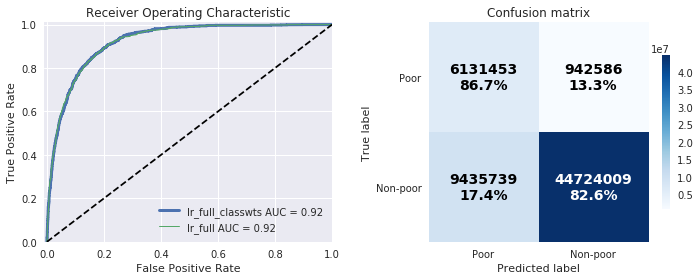

,lr_full_classwts,lr_full
accuracy,0.830513,0.910251
recall,0.866754,0.456232
precision,0.39387,0.661838
f1,0.541618,0.540131
cross_entropy,0.384733,0.212947
roc_auc,0.923196,0.923198
cohen_kappa,0.428159,0.483497


Actual poverty rate: 11.38% 
Predicted poverty rate: 25.09% 


In [12]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model with class_weight='balanced'
model = LogisticRegression(class_weight='balanced')
%time model.fit(X_train, y_train, sample_weight=w_train)

# Get an initial score
%time score = model.score(X_train, y_train, sample_weight=w_train)
print("In-sample score: {:0.2%}".format(score))
coefs = get_coefs_df(X_train, model.coef_[0])['abs']

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models='lr_full',
                                    store_model=True,
                                    model_name='full_classwts', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

## Oversampling and Undersampling <a class="anchor" id="over-and-under-sampling">
Another method is to resample the dataset so the classes are balanced. This can be done by either [oversampling or undersampling](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis). With oversampling, we randomly replicate samples of the under-represented class. This is typically the preferred method when the dataset is rather small, on the order of a few thousand records. Undersampling reduces the size of the dataset by sampling the over-represented class. This is a prefereable method when the dataset is very large, since reducing the size of the training set can also reduce the computational cost.

The Indonesia dataset contains about 53,000 records, with only 9% being in the 'poor' class. If we use undersampling, this will reduce our training set to ~9,600 records. If we use oversampling, we will increase the size of the dataset to about 97,000 records. We will try both approaches here and see which offers better performance.

Fortunately, there is a Python package called [imbalanced-learn](https://github.com/scikit-learn-contrib/imbalanced-learn) that provides implementations of several popular oversampling and undersampling techniques and is compatible with scikit-learn.

### Undersampling <a class="anchor" id="undersampling">
We'll apply undersampling using the `RandomUnderSampler` function from imbalanced-learn. This randomly takes samples the majority class to match the number of records from the under-represented class (or to reach a desired class ratio).

As a note, the imblearn functions return an array rather than a dataframe, so we'll need to store the column names if we want to inspect features or coefficients later.

X shape after undersampling:  (9584, 453)
CPU times: user 488 ms, sys: 757 µs, total: 489 ms
Wall time: 489 ms
CPU times: user 81.7 ms, sys: 701 ms, total: 783 ms
Wall time: 196 ms
In-sample score: 88.39%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


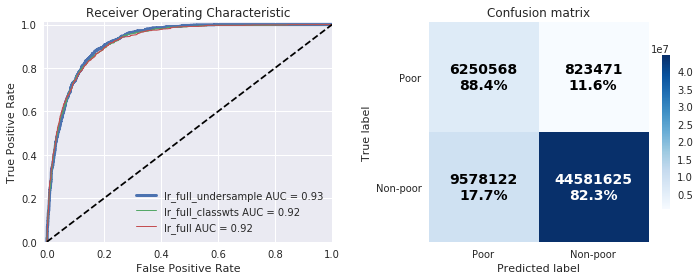

,lr_full_undersample,lr_full_classwts,lr_full
accuracy,0.830133,0.830513,0.910251
recall,0.883593,0.866754,0.456232
precision,0.394889,0.39387,0.661838
f1,0.545836,0.541618,0.540131
cross_entropy,0.392892,0.384733,0.212947
roc_auc,0.926233,0.923196,0.923198
cohen_kappa,0.44493,0.428159,0.483497


Actual poverty rate: 11.38% 
Predicted poverty rate: 25.57% 


In [13]:
from imblearn.under_sampling import RandomUnderSampler

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply random undersampling
X_train, y_train = RandomUnderSampler().fit_sample(X_train, y_train)
print("X shape after undersampling: ", X_train.shape)

# Fit the model
model = LogisticRegression()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Store coefficients
coefs = get_coefs_df(X_train, model.coef_[0], index=cols)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['lr_full_classwts', 
                                                    'lr_full'],
                                    store_model=True,
                                    model_name='full_undersample', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

This gives us a slightly better recall than using class weights. It's also considerably faster, since it reduces the size of the training set to less than 10,000 records. 

### Oversampling <a class="anchor" id="oversampling">
Next, we'll apply oversampling. One of the most popular oversampling methods is called SMOTE, or [Synthetic Minority Oversampling Technique](http://www.jair.org/media/953/live-953-2037-jair.pdf). This works by creating synthetic samples of the under-represented class by finding nearest neighbors and making minor random perturbations. 

X shape after oversampling:  (96680, 453)
CPU times: user 11.8 s, sys: 16.7 ms, total: 11.8 s
Wall time: 11.9 s
CPU times: user 210 ms, sys: 968 ms, total: 1.18 s
Wall time: 313 ms
In-sample score: 90.49%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


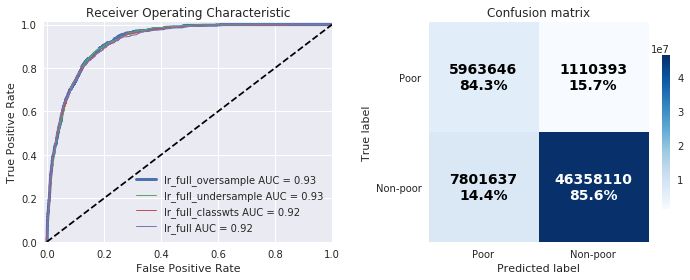

,lr_full_oversample,lr_full_undersample,lr_full_classwts,lr_full
accuracy,0.854459,0.830133,0.830513,0.910251
recall,0.843033,0.883593,0.866754,0.456232
precision,0.433238,0.394889,0.39387,0.661838
f1,0.572346,0.545836,0.541618,0.540131
cross_entropy,0.344135,0.392892,0.384733,0.212947
roc_auc,0.926334,0.926233,0.923196,0.923198
cohen_kappa,0.473514,0.44493,0.428159,0.483497


Actual poverty rate: 11.38% 
Predicted poverty rate: 22.14% 


In [14]:
from imblearn.over_sampling import SMOTE

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply oversampling with SMOTE
X_train, y_train = SMOTE().fit_sample(X_train, y_train)
print("X shape after oversampling: ", X_train.shape)

# Fit the model
model = LogisticRegression()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Store coefficients
coefs = get_coefs_df(X_train, model.coef_[0], index=cols)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['lr_full_undersample', 
                                                    'lr_full_classwts', 
                                                    'lr_full'],
                                    store_model=True,
                                    model_name='full_oversample', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

This gives us better results than undersampling and weighted classes, so we will use this method going forward. Note that it increases the size of the training set, but it appears to be more computationally efficient than using class weights.

# Cross Validation and Parameter Tuning <a class="anchor" id="cv-param-tuning"></a>

Now that we have a good method for dealing with the unbalanced dataset, let's also apply cross-validation and some hyperparameter tuning using the `LogisticRegressionCV` model as we did with the Malawi dataset.

X shape after oversampling:  (96680, 453)


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:718: UserWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number "
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:718: UserWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number "
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:718: UserWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number "
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:718: UserWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. In

CPU times: user 42min 51s, sys: 40min 31s, total: 1h 23min 22s
Wall time: 2min 43s
CPU times: user 550 ms, sys: 1.24 s, total: 1.79 s
Wall time: 56.1 ms
In-sample score: 90.51%
Best model parameters: C=1291.5496650148827


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


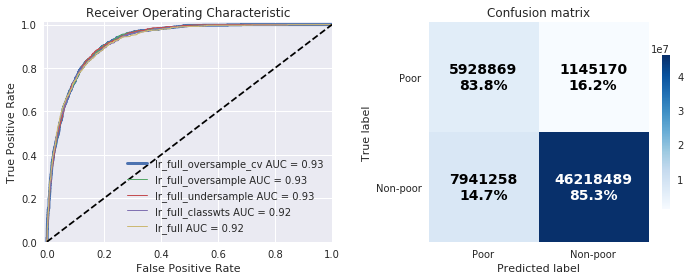

,lr_full_oversample_cv,lr_full_oversample,lr_full_undersample,lr_full_classwts,lr_full
accuracy,0.851611,0.854459,0.830133,0.830513,0.910251
recall,0.838116,0.843033,0.883593,0.866754,0.456232
precision,0.427456,0.433238,0.394889,0.39387,0.661838
f1,0.566159,0.572346,0.545836,0.541618,0.540131
cross_entropy,0.348544,0.344135,0.392892,0.384733,0.212947
roc_auc,0.925356,0.926334,0.926233,0.923196,0.923198
cohen_kappa,0.471316,0.473514,0.44493,0.428159,0.483497


Actual poverty rate: 11.38% 
Predicted poverty rate: 22.12% 


In [15]:
from sklearn.linear_model import LogisticRegressionCV

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply oversampling with SMOTE
X_train, y_train = SMOTE().fit_sample(X_train, y_train)
print("X shape after oversampling: ", X_train.shape)

# Fit the model
model = LogisticRegressionCV(Cs=10, cv=5, verbose=1)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
coefs = get_coefs_df(X_train, model.coef_[0], index=cols)

# Display best parameters
print("Best model parameters: C={}".format(model.C_[0]))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['lr_full_oversample',
                                                    'lr_full_undersample', 
                                                    'lr_full_classwts',  
                                                    'lr_full'],
                                    store_model=True,
                                    model_name='full_oversample_cv',
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

Using cross-validation and tuning the C parameter does not appear to have a major effect, but it is also much more computationally expensive to train the model. The precision metric is also still fairly low. We may be able to do better by performing more detailed feature selection and fine tuning the model further, but this serves as a decent baseline model for the Indonesia dataset for this project.

# Feature selection <a class="anchor" id="feature-selection"></a>

As we did with the Malawi dataset, let's pick a subset of features using the 'l1' regularization and see how the model performs using only this subset.

In [16]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply oversampling with SMOTE
X_train, y_train = SMOTE().fit_sample(X_train, y_train)
print("X shape after oversampling: ", X_train.shape)

# Fit the model
model = LogisticRegressionCV(cv=5, penalty='l1', Cs=[2e-3] , solver='liblinear')
%time model.fit(X_train, y_train)
coefs = get_coefs_df(X_train, model.coef_[0], index=cols)
coefs = coefs[coefs.coef != 0]
print("{} features selected".format(coefs.shape[0]))
display(coefs)
feats = coefs.index.values

X shape after oversampling:  (96680, 453)
CPU times: user 10.4 s, sys: 15.1 s, total: 25.5 s
Wall time: 9.14 s
62 features selected


,coef_std,coef,abs
geo_district,0.056450,0.056081,0.056450
geo_village,-0.011416,-0.013001,0.011416
der_hhsize,1.287300,1.215148,1.287300
hld_nbcell,-0.532633,-0.584829,0.532633
der_nchild10under,0.080005,0.073198,0.080005
der_nfemalesover10,0.096797,0.096013,0.096797
der_nliterate,-0.149187,-0.140277,0.149187
der_ninternetpast3mo,-0.150340,-0.187714,0.150340
geo_province__Central Java,0.246613,0.778255,0.246613
geo_province__East Java,0.110651,0.352155,0.110651


Now let's see how the model performs with this subset of features

X shape after oversampling:  (96680, 62)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   17.6s finished


CPU times: user 2min 15s, sys: 7min 15s, total: 9min 31s
Wall time: 18 s
CPU times: user 102 ms, sys: 470 ms, total: 572 ms
Wall time: 17.9 ms
In-sample score: 87.22%
Best model parameters: C=0.046415888336127774


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


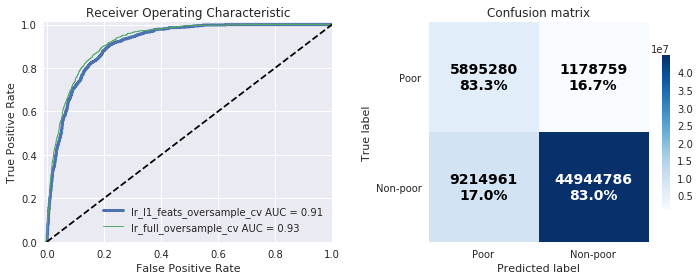

,lr_l1_feats_oversample_cv,lr_full_oversample_cv
accuracy,0.830262,0.851611
recall,0.833368,0.838116
precision,0.390151,0.427456
f1,0.531483,0.566159
cross_entropy,0.381388,0.348544
roc_auc,0.914608,0.925356
cohen_kappa,0.401993,0.471316


Actual poverty rate: 11.38% 
Predicted poverty rate: 24.04% 


In [17]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, selected_columns=feats)
cols = X_train.columns

# Apply oversampling with SMOTE
X_train, y_train = SMOTE().fit_sample(X_train, y_train)
print("X shape after oversampling: ", X_train.shape)

# Fit the model
model = LogisticRegressionCV(Cs=10, cv=5, verbose=1)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
coefs = get_coefs_df(X_train, model.coef_[0], index=cols)

# Display best parameters
print("Best model parameters: C={}".format(model.C_[0]))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, selected_columns=feats)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models='lr_full_oversample_cv',
                                    store_model=True,
                                    model_name='l1_feats_oversample_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

Using this method, we get slightly worse performance than the full feature model, but we have reduced the number of features to less than 100.

Let's inspect the coefficients for the features we selected and look at the consumable items that remained in the model.

In [18]:
cons_feats = [x.split('__')[0] for x in feats if x[0:5] == 'cons_']
print("{} consumables features selected:".format(len(cons_feats)))
for x in cons_feats:
    print(questions[x])

41 consumables features selected:
Dryshelled corn/corn rice
Wheat flour
Potato
Eastern tuna/skipjack tuna
Anchovies
Broiler meat
Broiler egg
Sweet canned liquid milk
Cucumber
Chillies
Orange
Lanzon
Tea
Powdered/bean coffee
Pepper
Soya sauce
Monosodium glutamate
Spice
Instant noodle
Other bread
Boil or steam cake
Fried food
A plate of rice accompanied by a mixture of dishes
Rice steamed in a banana leaf or coconut leaf
Noodle (with meatball/boiled/fried)
Other drinks (coffee, milk, etc) 
Clove filter cigarettes
Clove non filter cigarettes
In the case of own / rent-free house, an estimated monthly rent
Expenses on gasoline
Firewood and other fuels
Clothes maintenance material
Gasoline/pertamax
Lubricant
Motor vehicle's service and repair
Transport expenses
Ready-made clothes for men
Ready-made clothes for women
Ready-made clothes for children
Footwear
Kitchen utensils


As with Malawi, note that all of the remaining consumable items have negative coefficients, so households that responded "yes" to these questions are less likely to be poor. The list appears to make some intuitive sense, with items like various meats and cigarettes making the list.

# Logistic Regression Indonesia Summary <a class="anchor" id="summary"></a>

In this notebook, we demonstrated applying a logistic regression classifier to an unbalanced dataset. We introduced methods to deal with unbalanced classes such as SMOTE for oversampling, and highlighted the impact this has on how we evaluate a model. 

We will use the results of the logistic regression classifier as a baseline for the other algorithms we will consider. In the following notebooks, we will introduce some new concepts but will primarily focus on the unique characteristics of each classifier model. 

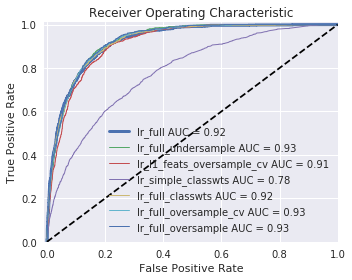

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa,pov_rate_error
lr_full,0.910251,0.456232,0.661838,0.540131,0.212947,0.923198,0.483497,-0.0313397
lr_full_undersample,0.830133,0.883593,0.394889,0.545836,0.392892,0.926233,0.44493,0.141912
lr_l1_feats_oversample_cv,0.830262,0.833368,0.390151,0.531483,0.381388,0.914608,0.401993,0.126578
lr_simple_classwts,0.727401,0.671885,0.199554,0.307714,0.568207,0.781698,0.195911,0.242064
lr_full_classwts,0.830513,0.866754,0.39387,0.541618,0.384733,0.923196,0.428159,0.137116
lr_full_oversample_cv,0.851611,0.838116,0.427456,0.566159,0.348544,0.925356,0.471316,0.107453
lr_full_oversample,0.854459,0.843033,0.433238,0.572346,0.344135,0.926334,0.473514,0.107608


In [19]:
evaluation.compare_algorithm_models(ALGORITHM_NAME, COUNTRY)